# Preparing `efficientdet` for Hailo-8

Set the variable 'd' to any number between 0 and 7

In [1]:
d=2 # Set to 0, 1, 2, ... 7
width=[512, 640, 768, 896, 1024, 1280, 1280, 1536]
height=[512, 640, 768, 896, 1024, 1280, 1280, 1536]

In [2]:
from pathlib import Path
import os

home = str(Path.home())
HOME=home+"/workspace/models"
if os.path.isdir(HOME)==False:
    !mkdir -p {HOME}
    print("Directory" + HOME + " created")

In [3]:
!pip3 install --upgrade pip
!pip3 install tf2onnx
!pip3 install onnx-simplifier

In [4]:
%matplotlib inline
from IPython.display import SVG
import tensorflow as tf
import numpy as np
from hailo_sdk_client import ClientRunner, __version__
from hailo_sdk_common.preprocessing import Normalization

In [5]:
%cd {HOME}
!git clone https://github.com/google/automl

/home/victorc/workspace/models
fatal: destination path 'automl' already exists and is not an empty directory.


In [6]:
print('TF version:', tf.__version__)
print('Hailo DFC version', __version__)

TF version: 2.4.1
Hailo DFC version 3.14.0


In [7]:
MODEL      = 'efficientdet-d'+str(d)

We now load the model, and pass a dummy image through the model to make sure that the weights are being loaded

Save the models as 'saved_model'

In [8]:
TMPMODEL= HOME+"/tmpmodel"

In [9]:
!mkdir -p {TMPMODEL}
!cd {TMPMODEL}
!wget -N https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco2/{MODEL}.tar.gz
!tar -zxf {MODEL}.tar.gz -C {TMPMODEL}

--2022-02-13 10:55:10--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco2/efficientdet-d2.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.209.240, 142.250.201.176, 142.250.178.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.209.240|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘efficientdet-d2.tar.gz’ not modified on server. Omitting download.



In [10]:
%cd {HOME}/automl/efficientdet
HPARAMS="image_size="+str(width[d])+"x"+str(height[d])
print(HPARAMS)
!python model_inspect.py --runmode=saved_model \
  --model_name={MODEL} --ckpt_path={TMPMODEL}/{MODEL} \
  --hparams={HPARAMS} \
  --saved_model_dir={TMPMODEL}/{MODEL}-saved_model

/home/victorc/workspace/models/automl/efficientdet
image_size=768x768
2022-02-13 10:55:11.967574: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-13 10:55:11.967597: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-02-13 10:55:12.941741: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-13 10:55:12.942023: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-13 10:55:12.942139: W tensorflow/stream_executor

convert the model to ONNX

In [11]:
!python3 -m tf2onnx.convert --saved-model {TMPMODEL}/{MODEL}-saved_model --output {TMPMODEL}/{MODEL}.onnx --opset 12

2022-02-13 10:55:38.968753: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-13 10:55:38.968863: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-02-13 10:55:39.710779: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-13 10:55:39.710911: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-13 10:55:

2022-02-13 10:55:41,410 - WARNING - Importing a function (MetaGraph import) with ops with custom gradients. Will likely fail if a gradient is requested.
2022-02-13 10:55:41,412 - WARNING - Importing a function (MetaGraph import) with ops with custom gradients. Will likely fail if a gradient is requested.
2022-02-13 10:55:41,414 - WARNING - Importing a function (MetaGraph import) with ops with custom gradients. Will likely fail if a gradient is requested.
2022-02-13 10:55:41,415 - WARNING - Importing a function (MetaGraph import) with ops with custom gradients. Will likely fail if a gradient is requested.
2022-02-13 10:55:41,416 - WARNING - Importing a function (MetaGraph import) with ops with custom gradients. Will likely fail if a gradient is requested.
2022-02-13 10:55:41,417 - WARNING - Importing a function (MetaGraph import) with ops with custom gradients. Will likely fail if a gradient is requested.
2022-02-13 10:55:41,418 - WARNING - Importing a function (MetaGraph import) with o

2022-02-13 10:55:45.848962: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-13 10:55:45.894977: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1689600000 Hz
2022-02-13 10:55:48,497 - INFO - Signatures found in model: [serving_default].
2022-02-13 10:55:48,497 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-02-13 10:55:48,502 - INFO - Output names: ['detections:0']
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.
2022-02-13 10:55:48,614 - WARNING - Issue encountered when serializing global_step.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.
Type is unsupported, or the types of 

In [12]:
!python3 -m onnxsim {TMPMODEL}/{MODEL}.onnx {TMPMODEL}/{MODEL}.sim.onnx --input-shape 1,{width[d]},{height[d]},3

Simplifying...
Note: The input shape of the simplified model will be overwritten by the value of '--input-shape' argument. Pass '--dynamic-input-shape' if it is not what you want. Run 'python3 -m onnxsim -h' for details.
Checking 0/3...
Checking 1/3...
Checking 2/3...
Ok!


For the `efficientdet` model, we would like to port to Hailo not only the model itself, but also the normalization, and the NMS post processing. The way to do that, is to address each of these items seperately. 

We reccomend to examine the model in 'Netron' to get a better understanding of the model

### Parsing the ONNX model

In [13]:
start_node = "efficientnet-b"+str(d)+"/stem/conv2d/Conv2D"

end_nodes  = [
    'class_net/class-predict/BiasAdd',
    'class_net/class-predict_1/BiasAdd',
    'class_net/class-predict_2/BiasAdd',
    'class_net/class-predict_3/BiasAdd',
    'class_net/class-predict_4/BiasAdd',
    'box_net/box-predict/BiasAdd',
    'box_net/box-predict_1/BiasAdd',
    'box_net/box-predict_2/BiasAdd',
    'box_net/box-predict_3/BiasAdd',
    'box_net/box-predict_4/BiasAdd'
]

mean_list = [127, 127, 127]
std_list = [128, 128, 128]
norm_obj = Normalization(mean_list, std_list)
runner = ClientRunner()
_ = runner.translate_onnx_model(TMPMODEL + "/" + MODEL + '.sim.onnx',
    MODEL,
    start_node_name=start_node,
    end_node_names=end_nodes,
    integrated_preprocess=norm_obj)

[info] Restoring ONNX model efficientdet-d2 from export file
[info] Translation started on ONNX model efficientdet-d2
[info] Translation completed on ONNX model efficientdet-d2
[info] Initialized runner for efficientdet-d2


Let's save the current state of the runner, after the parsing of the network.

In [14]:
hailo_model_har_name=MODEL + '.har'
runner.save_har(hailo_model_har_name)

2022-02-13 10:56:31.667814: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-13 10:56:31.667833: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


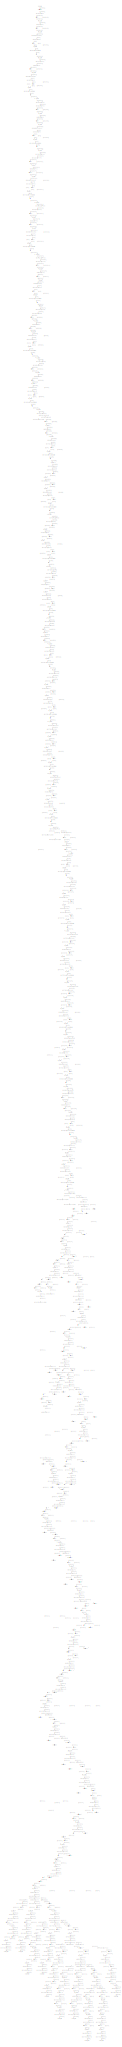

In [15]:
!hailo visualizer {hailo_model_har_name} --no-browser
SVG('out.svg')

Quantize the model

In [16]:
calibset = np.zeros([1,height[d], width[d], 3])

In [17]:
runner.quantize(calibset, batch_size=1, calib_num_batch=1)

[info] Starting Quantization
[warning] DEPRECATION WARNING: quantization parameter `batch_size` will be deprecated in the near future.Please use the following model script command instead to configure `batch_size`:
		model_optimization_config(calibration, batch_size=<value>)
[warning] DEPRECATION WARNING: quantization parameter `calib_num_batch` will be deprecated in the near future.Please configure `calibset_size` instead using the following command:
		model_optimization_config(calibration, calibset_size=<value>)
[info] Creating graph from hn
[warning] Layer type normalization does not supported elementwise add
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
[info] Starting Equalization
[info] Equalization configuration:
[info]     Default policy: enabled
[info]     Mode: min_based
[info] Starting Equalization of component 1 out of 1
[info] Skipped Equalization of layers {'efficientdet-d2/normalization68', 'efficientdet-d

[info] The time for equalization 00:00:02.18
[info] Equalization is done
[info] Translating params for efficientdet-d2
[warning] data is all the same is for limvals [0.0, 0.0]
[warning] changing to limvals [0.0, 1.0]
[warning] data is all the same is for limvals [-0.9921875, -0.9921875]
[warning] changing to limvals [-0.9921875, 1.0]
[warning] No shifts available for layer efficientdet-d2/normalization87, using max shift instead. delta=3.319137851902407
[warning] data is all the same is for limvals [-0.9921875, -0.9921875]
[warning] changing to limvals [-0.9921875, 1.0]
[warning] One or more of the exponent values of the piecewise m*2^(e) representation is negative, e = 10 - EBIAS - beta - shift + e* : slopes_e: [ 1  1 -1 -2 -2 -2 -1  1  1] , shift: 1 
[info] Retry quantization after params update to layer efficientdet-d2/activation1.
[warning] data is all the same is for limvals [0.0, 0.0]
[warning] changing to limvals [0.0, 1.0]
[warning] data is all the same is for limvals [-0.99218

BackendQuantizationException: Quantization failed in layer due to unsupported required slope 4 at layer efficientdet-d2/activation2, ActivationType.sigmoid, limvals_weights: None, limvals_in: [-57.80234822188273, 37.909332], limvals_out: [0.0, 1.0].

In [ ]:
with open('model.alls', 'w') as FH:
    FH.write('context_switch_param(mode=enabled, max_memory_utilization=0.5, max_control_utilization=0.5, max_compute_utilization=0.5)\n')
    FH.write('resources_param(max_control_utilization=0.75, max_memory_utilization=0.65, max_compute_utilization=0.75)\n')

In [ ]:
Compile the model

In [ ]:
hef = runner.get_hw_representation(fps=90, allocator_script_filename='model.alls')
with open(MODEL + '.hef', 'wb') as FH:
    FH.write(hef)

In [ ]:
runner.save_har(hailo_model_har_name)
!hailo profiler {hailo_model_har_name} --fps 20